---
layout: code-post
title: AlphaZero for Brandub
description: We provide a from scratch implementation of AlphaZero to learn how to play brandub.
tags: [tafl, neural nets]
---

In this post I'm going to explore how to implement [AlphaZero](https://arxiv.org/pdf/1712.01815.pdf)
to learn how to play Brandub (a tafl variant). I previously put together a [Brandub package](https://github.com/kevinnowland/brandub)
which I won't use directly, but whose code I will modify as needed. You can find the rules of the
game there.

The main purpose of this is to prove that I understand the algorithm well enough to implement
a very crude version of it. How crude? I doubt the best trained player after even a few days of training
will be able to play very well. My big question is whether the trained model can beat me, who has
never played a full game before despite all this coding that I've done.

UPDATE: The moves are still mostly random. Training did not go well! I believe this is
hyperparameter related as well as not putting enough time into it. I intend to come
back and mess around with the model. I can restart the optimizer and I'd like
to save games for a few rounds of training and use them to bootstrap up.


## Algorithm description

### Game play technology

AlphaZero plays games using two main pieces of technology. The first is a neural network $f\_\theta(s)$ with
parameters $\theta$ which takes the current game state $s$ and outputs $(p, z)$ where where $p$ is a probability
vector of all possible moves and $z \in [-1, 1]$ is an estimated game score for the current player with -1 being a
loss, 0 a draw, and 1 a win. Only the neural network parameters $\theta$ will be learned.

One could play 
just using $f\_\theta$ by choosing moves according to the output move probabilities $p$, 
but instead of doing this, we rely on
the second piece of technology, a Monte Carlo Tree Search (MCTS) algorithm. The tree search
uses the neural network to explore the space of moves and choose the best one taking into account
how the game might proceed. The neural network output, as we will
see later, is extremely raw and can suggest moves which are illegal (moving an opponent's piece) or 
even impossible (moving off the board). In addition to suggesting moves which will likely lead to victory
for the curernt player, the tree search algorithm helps encode the rules of the game
by only exploring legal moves. The tree
search is not learned directly, but does take as inputs the neural network $f\_\theta$ and current game state. 
The output is a policy $\pi$, a probability vector that is used to select the next move.

### Learning

Give the neural network and MCTS algorithm, play proceeds until a game ends at step $T$.
At each step $t$ of the game we have neural network output $(p\_t, v\_t)$ as well as 
the policy $\pi\_t$ governing move selection. The final game result is $s\_T \in \{-1, 0, 1\}$. 
The loss $\ell\_t$ for a step is
$$
  \ell\_t = (v\_t - s\_T)^2 - \pi\_t^t\log p\_t + c \|\theta\|^2,
$$
where $c$ is an $\ell^2$-regularization parameter. Thus we are looking at mean squared
error for the 
predicted output $v$ with cross-entropy forcing predicted moved probabilities $p$ to look like 
the MCTS policy $\pi$ with a regularization term.
The overall loss function is the average of this over the $T$ moves making up the game.

After each game, we backpropagate from the loss function through the nerual network to
change the neural network parameters $\theta$. Note that while policies $\pi\_t$ do depend on 
$\theta$ since the MCTS takes the nerual network as input, we will pretend it does not and thus 
does not affect backpropogation. Since $p$ is driven to look like the policy $\pi$, this
helps the neural network learn the games rules since $\pi$ only contains values for
legal moves.


## Implementation

### Game State

The state of a game is encoded similarly but not identically to what was done in the brandub
package. The state tensor is a stack of 7x7 binary tensors and some constant tensors.
The first layer encodes the current player's pawns and the second layer is the current player's
monarch. The current player might be the attacker and not have a monarch, but that is fine and
the input plane will be all zero. These layers repeat with the opponent's positions. 
AlphaZero maintains 8 timesteps of history, but we will try to keep only 3. While the connections
from these historical planes
will be learned, the main use is to avoid draws by repetition.
AlphaZero for Chess contains two more constant planes, 
either 1 or 0, depending on if the current position has repeated once or twice before.
Probably the order matters, although I am not sure. Since brandub ends in a draw with only a 
single repeated position, we do not need to encode this information for the player.

In addition we will include a constant plane that is not repeated to indicate which player is
playing, either 0 for defense or 1 for attack.

Overall, this leads to a game state tensor of size $7\times7\times(4\times3 + 1)$, i.e.,
we have 637 features.

In [4]:
import torch


def get_initial_game_state():
    """returns pytorch tensor encoding initial brandub game state"""
    
    game_state = torch.zeros(13, 7, 7, dtype=torch.float32)
    
    # attacking pawns
    game_state[0, 3, 0] = 1
    game_state[0, 3, 1] = 1
    game_state[0, 3, 5] = 1
    game_state[0, 3, 6] = 1
    game_state[0, 0, 3] = 1
    game_state[0, 1, 3] = 1
    game_state[0, 5, 3] = 1
    game_state[0, 6, 3] = 1
    
    # defensive pawns
    game_state[2, 3, 2] = 1
    game_state[2, 3, 4] = 1
    game_state[2, 2, 3] = 1
    game_state[2, 4, 3] = 1
    
    # defensive monarch
    game_state[3, 3, 3] = 1
    
    # attack's turn
    game_state[12, :, :] = 1
    
    return game_state

def board_shadow(board, is_attack_turn):
    """ return a 7x7 tensor encoding current state with
    -1 being an attacking pawn, 1 a defensive pawn,
    2 the monarch.
    
    board is a 4x7x7 tensor
    is_attack_turn is a boolean
    
    This is used to look for draws with game states"""
    
    raw_shadow = board[0, :, :] + 2 * board[1, :, :] - \
        board[2, :, :] - 2 * board[3, :, :]
    
    if is_attack_turn:
        return -1 * raw_shadow
    else:
        return raw_shadow
    
    
def game_shadow(game_state):
    """ returns the board shadow for the current board
    and player. """
    
    return board_shadow(game_state[:4, :, :], game_state[12, 0, 0] == 1)

In [5]:
initial_game_state = get_initial_game_state()
print(game_shadow(initial_game_state))

tensor([[-0., -0., -0., -1., -0., -0., -0.],
        [-0., -0., -0., -1., -0., -0., -0.],
        [-0., -0., -0.,  1., -0., -0., -0.],
        [-1., -1.,  1.,  2.,  1., -1., -1.],
        [-0., -0., -0.,  1., -0., -0., -0.],
        [-0., -0., -0., -1., -0., -0., -0.],
        [-0., -0., -0., -1., -0., -0., -0.]])


### Movement

Movement will be encoded as a $7\times7\times24$ tensor. The first two coordinates
indicate the position on the board where a piece should be found and the
final coordinate indicates the direction. The value modulo 6 then adding 1 (not
modulo 6) is the amount of spaces to move, raw values between 0 and 5 indicate
moving down, 6 to 11 moving up, 12 to 17 moving right, 18 to 23 moving
left. $(7, 7, 4)$ will also be the shape of the probability vector put out by the neural net and
will include invalid moves. The first step of the MCTS will be to reduce this
only to valid moves. A singular move will be an index tensor that we can samples
using the `Categorical` object in `torch.distributions.categorical`.

We will need auxiliary functions to find valid moves and then perform
those moves. Again, since we're trying to remove unnecessary cruft, we will
not verify many things, such as piece existence. In the following code block
we will write auxiliary functions involved with finding valid moves
and the new position of a piece given some move.

In [6]:
def is_forest(position_2d):
    """ returns whether the first two coords of
    position_2d is a forest"""
    return position_2d[0] in [0, 6] and position_2d[1] in [0, 6]


def is_castle(position_2d):
    """ returns whether the first two coords of position_2d
    is a castle"""
    return position_2d[0] == 3 and position_2d[1] == 3
   

def find_piece_plane(board, position_2d, planes=[2, 3, 0, 1]):
    """ returns the plane of piece at given (i, j) position """
    for k in planes:
        if board[k, position_2d[0], position_2d[1]] == 1:
            return k
        
        
def find_piece_at_position(board, position_2d):
    """ returns the (i, j, k) position of the piece at position (i, j) 
    if some is present else returns None """
    
    k = find_piece_plane(board, position_2d, [2, 3, 0, 1])
    if k is not None:
        return (k, position_2d[0], position_2d[1])
    else:
        return None

        
def valid_moves(board, position):
    """ find valid movement indices 0-24 for a piece
    that is (assumed to be) at position, which is a tensor with length 2"""
    
    is_pawn = board[1, position[0], position[1]] == 0
    
    shadow = board[0, :, :] + board[1, :, :] + board[2, :, :] + board[3, :, :]
    
    def check_direction(direction_vector):
        """ get valid moves in the given direction
        direction must be [+/-1, 0] or [0, +/-1] torch tensors
        """

        valid_moves = []

        coord = 0 if direction_vector[0] != 0 else 1
        positive_direction = direction_vector[coord] == 1
        end_value = 6 if positive_direction else 0
        
        if coord == 0:
            if positive_direction:
                base = 0
            else:
                base = 6
        else:
            if positive_direction:
                base = 12
            else:
                base = 18

        keep_going = position[coord] != end_value
        i = 0
        while keep_going:
            i += 1

            new_pos = position + i * direction_vector

            # stop if run into a piece
            if shadow[tuple(new_pos)] == 1:
                break

            # ignore the castle
            if is_castle(new_pos):
                continue

            keep_going = new_pos[coord] != end_value

            # if pawn and at the wall, see if its a forest but don't add
            if not keep_going and is_pawn and is_forest(new_pos):
                break

            valid_moves.append(base + i - 1)

        return valid_moves
    
    direction_vectors = (
        torch.tensor([1, 0]),
        torch.tensor([-1, 0]),
        torch.tensor([0, 1]),
        torch.tensor([0, -1])
    )

    return [
        direction
        for dvec in direction_vectors
        for direction in check_direction(dvec)
    ]


def valid_move_indices(board):
    move_indices = [
        (move_index, pos[1], pos[2])
        for pos in board[:2, :, :,].nonzero(as_tuple=False)
        for move_index in valid_moves(board, pos[1:])
    ]
    
    return move_indices


def valid_move_tensor(board):
    """ get tensor of all valid moves. Only pieces on the first
    two planes can move. 
    
    Returns 24x7x7 binary tensor """
    
    # get all pieces that can move
    move_indices = valid_move_indices(board)
    
    move_tensor = torch.zeros(24, 7, 7)
    for move_index in move_indices:
        move_tensor[move_index] = 1
        
    return move_tensor


def find_new_position(board, move):
    """ find the piece at the given
    position and return a tuple containing
    the pieces new location.
    
    NOTE: assumes piece is on the first or second plane """
    
    # whether to move vertically or horizontally
    move_vertical = move[0] < 12
    
    # how much to move
    direction = 1 if move[0] % 12 < 6 else -1
    move_val = direction * (move[0] % 6 + 1)
    
    # find where the piece is
    plane = find_piece_plane(board, move[1:], [0, 1])
    
    if move_vertical:
        return (plane, move[1] + move_val, move[2])
    else:
        return (plane, move[1], move[2] + move_val)

One thing we negelcted above was checking that any moves were possible when
checking to see if a game was over.

In [7]:
def get_monarch_index(game_state):
    """ return which game state layer encodes the defensive monarch 
    for the current board """
    if game_state[12, 0, 0] == 1:
        return 3
    else:
        return 1

    
def attack_victory(board, monarch_index):
    """ attack wins if the monarch is not on the current board"""
    
    return board[monarch_index, :, :].max() == 0


def defense_victory(board, monarch_index):
    """ defense wins if the monarch is in the forest """
    
    if board[monarch_index, 0, 0] == 1 or \
        board[monarch_index, 0, 6] == 1 or \
        board[monarch_index, 6, 0] == 1 or \
        board[monarch_index, 6, 6] == 1:
        return True
    
    if monarch_index == 1:
        no_attackers = board[2, :, :].sum() == 0
    else:
        no_attackers = board[0, :, :].sum() == 0
    return no_attackers
        

def drawn_game(board, game_state):
    """ take a new board and compare to the boards in the game state
    to see if it would result in a draw. Also checks to make sure
    the new player can move
    
    NOTE: This assumes that the current player for board is DIFFERENT THAN
    the current player in the game_state 
    
    NOTE: Do not bother checking most recent game state, as we
    assume the presented board is after a move. """
    
    # tie if the new player cannot move
    valid_moves = valid_move_tensor(board)
    if valid_moves.sum() == 0:
        return True
    
    is_attack_turn = game_state[12, 0, 0] == 1
    new_board_shadow = board_shadow(board, not is_attack_turn)
    
    # check two moves ago
    board_shadow_1 = board_shadow(game_state[4:8, :, :], not is_attack_turn)
    
    if torch.all(torch.eq(new_board_shadow, board_shadow_1)):
        return True
    else:
        board_shadow_2 = board_shadow(game_state[8:12, :, :],
                                      is_attack_turn)
        return torch.all(torch.eq(new_board_shadow, board_shadow_2))

def get_end_value(board, game_state):
    """ return 1, -1, 0, or None based on whether
    the player making the move won, lost, or forced
    a draw.
    
    Assumes the new board has the players flipped
    from the game state but is checking value
    for the player of game state """
    
    attacker_made_move = game_state[12, 0, 0] == 1
    monarch_index = 1 if attacker_made_move else 3
    
    if attack_victory(board, monarch_index):
        if attacker_made_move:
            return 1
        else:
            return -1
    elif defense_victory(board, monarch_index):
        if attacker_made_move:
            return -1
        else:
            return 1
    elif drawn_game(board, game_state):
        return 0
    else:
        return None

Now we write functions that allow us to advance game state by performing a move
and then capturing the pieces.

In [8]:
def is_piece_captured(board, position):
    """ determine if a piece at (i, j, k) is captured.
    
    NOTE: does not check that a piece is at the position
    
    NOTE: This does not validate that the raw_board is a
    vaid raw_board. """
    
    i = position[1]
    j = position[2]

    topography_inds_corners = [(0, 0), (0, 6), (6, 0), (6, 6)]

    if position[0] == 0 or position[0] == 2:
        # pawn logic
        
        if position[0] == 0:
            enemy_board = board[2, :, :] + board[3, :, :]
        else:
            enemy_board = board[0, :, :] + board[1, :, :]
        
        if board[3, 3, 1] + board[3, 3, 3] == 0:
            # no monarch? then castle is threat
            topography_inds = topography_inds_corners + [(3, 3)]
        else:
            topography_inds = topography_inds_corners

        topography = torch.zeros(7, 7)
        for ind in topography_inds:
            topography[ind] = 1
        bad_things = enemy_board + topography

        if i == 0 or i == 6:
            # on top or bottom (can't be in corner)
            if bad_things[i, j-1] == 1 and bad_things[i, j+1] == 1:
                return True
            else:
                return False
        elif j == 0 or j == 6:
            # on left or right side (can't be in corner)
            if bad_things[i-1, j] == 1 and bad_things[i+1, j] == 1:
                return True
            else:
                return False
        else:
            # otherwise just check
            if bad_things[i, j-1] == 1 and bad_things[i, j+1] == 1:
                return True
            elif bad_things[i+1, j] == 1 and bad_things[i-1, j] == 1:
                return True
            else:
                return False

    elif position[0] == 1 or position[0] == 3:
        # monarch logic
        
        if position[2] == 1:
            enemy_board = board[2, :, :]
        else:
            enemy_board = board[0, :, :]

        if i != 3 or j != 3:
            # empty castles are threats
            topography_inds = topography_inds_corners + [(3, 3)]
        else:
            topography_inds = topography_inds_corners

        topography = torch.zeros(7, 7)
        for ind in topography_inds:
            topography[ind] = 1
        bad_things = enemy_board + topography

        if (i, j) in [(3, 2), (3, 3), (3, 4), (2, 3), (4, 3)]:
            # in or next to castle have to be surrounded
            if bad_things[i+1, j] == 1 and bad_things[i-1, j] == 1 \
                and bad_things[i, j+1] == 1 and bad_things[i, j-1] == 1:
                return True
            else:
                return False
        else:
            if (i, j) in [(0, 0), (0, 6), (6, 0), (6, 6)]:
                # safe in corner
                return False
            elif i == 0 or i == 6:
                # top or bottom: non corner
                if bad_things[i, j+1] == 1 and bad_things[i, j-1] == 1:
                    return True
                else:
                    return False
            elif j == 0 or j == 6:
                # left or right: non corner
                if bad_things[i+1, j] == 1 and bad_things[i-1, j] == 1:
                    return True
                else:
                    return False
            else:
                # any other spot on board
                if bad_things[i+1, j] == 1 and bad_things[i-1, j] == 1:
                    return True
                elif bad_things[i, j+1] == 1 and bad_things[i, j-1] == 1:
                    return True
                else:
                    return False
    else:
        msg = "position[0] must be in {0, 1, 2, 3}"
        raise Exception(msg)


def game_state_move(game_state, move):
    """ advance game state by moving piece, performing captures, 
    flipping players, and returning a new game state. Also
    returns if the game is over as needed.
    
    NOTE: asumes the move is valid but does not check 
    
    This takes about 0.55 ms"""
    
    # perform the move
    old_board = game_state[:4, :, :]
    new_pos = find_new_position(game_state[:4, :, :], move)
    old_pos = (new_pos[0], move[1], move[2])
    
    new_board_ = torch.zeros(4, 7, 7)
    new_board_[:, :, :] = old_board
    new_board_[old_pos] = 0
    new_board_[new_pos] = 1
    
    # check any pieces near the given piece to see if they are captured
    # if so, remove them from the new_board
    i = new_pos[1]
    j = new_pos[2]
    
    for check_pos in [(i, j), (i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
        
        if check_pos[0] >= 0 and check_pos[0] <= 6 \
            and check_pos[1] >=0 and check_pos[1] <= 6:
            
            piece_pos_ = find_piece_at_position(new_board_, check_pos)
            
            if piece_pos_ is not None:
                if is_piece_captured(new_board_, piece_pos_):
                    new_board_[piece_pos_] = 0
    
    # flip players
    new_board = torch.zeros(4, 7, 7, dtype=torch.float32)
    new_board[:2, :, :] = new_board_[2:, :, :]
    new_board[2:, :, :] = new_board_[:2, :, :]
    
    # see if the new_board_ is in a victory state
    # return if so
    end_game_value = get_end_value(new_board, game_state)
        
    if end_game_value is not None:
        return None, end_game_value
    else:
        
    
        # form the new game_state
        new_game_state = torch.zeros(13, 7, 7, dtype=torch.float32)

        # update boards
        new_game_state[:4, :, :] = new_board
        new_game_state[4:8, :, :] = game_state[:4, :, :]
        new_game_state[8:12, :, :] = game_state[4:8, :, :]

        # update player
        new_game_state[12, :, :] = 1 - game_state[12, :, :]
    
        return new_game_state, None

We could now play a game starting from the initial game state provided by `get_initial_game_state()`
and applying moves using `game_state_move()`. We would have to be careful to only supply
valid moves though, because the board could easily get into an invalid state since we are
not verifying many things. As written, `game_state_move()` returns two values, one of which will
always be `None`. The `new_game_state` is returned if the game is not over and the second
value is returned as `None`. If the game is over, `new_game_state` will be `None` (and returned first)
and the second parameter will be 1 if the player who submitted the move won, -1 if they lost because
of their move, and 0 if the game ended in a draw.

### Monte Carlo Tree Search

Now that we have a playable game that can also find valid moves, we should be able to implement the
Monte Carlo Tree Search algorithm. The main references I'm using fo this are [this blog post](https://www.analyticsvidhya.com/blog/2019/01/monte-carlo-tree-search-introduction-algorithm-deepmind-alphago/) for explicit examples of how MCTS proceeds,
the [mcstpy package](https://github.com/int8/monte-carlo-tree-search) from which I will liberally take code, and an AlphaZero 
explainer [here](https://jonathan-hui.medium.com/monte-carlo-tree-search-mcts-in-alphago-zero-8a403588276a). Also
[this useful graphic](https://medium.com/applied-data-science/alphago-zero-explained-in-one-diagram-365f5abf67e0) and
[this tutorial](https://web.stanford.edu/~surag/posts/alphazero.html)
by a grad student.
It appears that one of the main
differences between the AlphaZero MCTS implementation and the standard implementation is that game state values
are not obtained via rollout and are instead obtained directly from the neural net evaluator.
We can test it out initially with a dummy move probability
tensor generator and values.

To program this, we will create a new `Node` class that is the base unit for the tree created during MCTS.
This will not be functional programming, as I believe it makes more sense to keep nodes around and update
the relevant values they hold versus a more functional approach. I'm open to hearing about how this is wrong,
though!

The node will know about its children, its parent, the probability that it was chosen by its parent
initially, the predicted value of that position for whoever is playing it, and the raw probabilities 
for the next step. A node also needs to know how to backpropagate a value to its parent, as the
nodes perceived value will change at every step. The trickiest part is thinking about
what value to give to a node and what value to propagate. The neural network $f\_\theta$ always
provides the value from the current player's perspective. Since the player of the child node
is the opponent of its parent node, the child nodes value to the parent is the opposite of
what the child perceives.

But what does that mean for the backpropagation? A parent node chooses the node with
the highest value (since the child values are given according to what the parent thinks).
The child does the same thing, choosing what is a grandchild node to the original parent node.
The grandchild will send the negative of its value to the child node because the child node needs
to become less attractive to the original parent as the child chose a node to help itself, not
its parent.

In [9]:
class Node:
    
    def __init__(self,
                 is_attacker,
                 move_taken,
                 parent,
                 game_state,
                 p,
                 v,
                 raw_child_p_tensor,
                 game_over):
        
        self.__is_attacker = is_attacker
        self.__move_taken = move_taken
        self.__parent = parent
        self.__children = []
        self.__game_state = game_state
        self.__p = p
        self.__v = v
        self.__w = float(v)
        self.__q = torch.tensor(0, dtype=torch.float32)
        self.__raw_child_p_tensor = raw_child_p_tensor
        self.__game_over = game_over
        self.__n = torch.tensor(0, dtype=torch.float32)
    
    @property
    def is_attacker(self):
        return self.__is_attacker
    
    @property
    def move_taken(self):
        return self.__move_taken
    
    @property
    def parent(self):
        return self.__parent
    
    @property
    def children(self):
        return self.__children
    
    @property
    def game_state(self):
        return self.__game_state
    
    @property
    def board(self):
        return self.__game_state[:4, :, :]
    
    @property
    def p(self):
        return self.__p
    
    @property
    def v(self):
        return self.__v
    
    @property
    def w(self):
        return self.__w
    
    @property
    def n(self):
        return self.__n
    
    @property
    def raw_child_p_tensor(self):
        return self.__raw_child_p_tensor
    
    @property
    def q(self):
        if self.n == 0:
            return 0
        else:
            return self.w / self.n
    
    @property
    def u(self):
        # c_puct = 0.5 in this implementation
        return self.q + 0.5 * self.p * (torch.sqrt(self.parent.n) / (1 + self.n))
    
    @property
    def game_over(self):
        return self.__game_over
    
    @property
    def has_children(self):
        return len(self.children) > 0
    
    def increment_n(self):
        self.__n += 1
        
    def add_children(self, evaluator):
        """ use the evaluator (the neural net) to
        add child nodes for each possible move"""
        
        # find all posible valid moves and their raw probabilities
        # then convert to new probabilities
        move_tensor = valid_move_tensor(self.board)
        
        temp_p = move_tensor * self.raw_child_p_tensor
        new_p = temp_p / temp_p.sum()
        
        for move_index in move_tensor.nonzero(as_tuple=False):
            
            new_game_state, end_game_value = game_state_move(self.game_state,
                                                             move_index)
            
            node_p = new_p[move_index[0], move_index[1], move_index[2]]
            
            if new_game_state is not None:
                node_child_p_tensor, node_v = evaluator(new_game_state)
                new_node = Node(not self.is_attacker,
                                move_index,
                                self,
                                new_game_state,
                                node_p,
                                -node_v,
                                node_child_p_tensor,
                                False)
            else:
                new_node = Node(not self.is_attacker,
                                move_index,
                                self,
                                None,
                                node_p,
                                end_game_value,
                                None,
                                True)
            
            self.__children.append(new_node)
            
    def backpropagate(self, new_v):
        """ add this to our v and to the parent v """
        self.__w += new_v
        if self.parent is not None:
            self.parent.backpropagate(-new_v)
            
    def choose_favorite_child(self):
        """ returns the child with the highest u value """
        try:
            return max(self.children, key=lambda c: c.u)
        except ValueError:
            print(game_shadow(self.game_state))
            print('is_attacker:', self.is_attacker)
            raise
    
    def detach_parent(self):
        """ set parent to None """
        self.__parent = None
    
    def get_child(self, move):
        """ return child node based on the move taken """
        
        for child in self.children:
            if torch.all(torch.eq(child.move_taken, move)):
                child.detach_parent()
                return child

Note how the backpropagation gives the node the value given to it but then passes the opposite 
value to its own parent. In the code below we perform an iteration as we reasoned above: the
chosen grandchild node gives its parent the negative of its own value and chain of
backpropagations continues.

In [10]:
def mcts_iteration(root_node, evaluator):
    """ run one iteration of the MCTS """
        
    node = root_node
        
    keep_going = True
    while keep_going:
        
        if node.n == 0 and node.parent is not None:
            node.parent.backpropagate(-node.v)
            node.increment_n()
            keep_going = False
        else:
            if node.has_children:
                node.increment_n()
                node = node.choose_favorite_child()
            else:
                if node.game_over:
                    node.parent.backpropagate(-node.v)
                    node.increment_n()
                    keep_going = False
                else:
                    node.add_children(evaluator)
                    node.increment_n()
                    node = node.choose_favorite_child()

            
def get_move_probabilities(root_node, evaluator, num_iterations):
    """ run the mcts with a given number of iterations 
    
    returns moves and their probabilities """
    
    for _ in range(num_iterations):
        mcts_iteration(root_node, evaluator)
        
    policy_tensor = torch.zeros(7, 7, 24, dtype=torch.float32)
    
    moves = [
        child.move_taken
        for child in root_node.children
        if child.n > 0
    ]
    
    visits = torch.tensor([
        child.n
        for child in root_node.children
        if child.n > 0
    ], dtype=torch.float32)
        
    return moves, visits / visits.sum()


def convert_to_policy_tensor(moves, probs):
    """ convert moves and probs lists into a policy tensor"""
    
    move_tensor = torch.zeros(24, 7, 7, dtype=torch.float32)
    
    for i in range(len(moves)):
        move_tensor[tuple(moves[i])] = probs[i]
        
    return move_tensor

We can now have the computer play a game against itself once we give it an
evaluator. There's a lot we need to return after a game is over in order
to evaluate the loss function, which we'll have it do.

In [11]:
from torch.distributions.categorical import Categorical


def get_initial_node(evaulator):
    """ get the initial node """
    
    initial_state = get_initial_game_state()
    p, v = evaulator(initial_state)
    
    return Node(is_attacker=True,
                move_taken=None,
                parent=None,
                game_state=initial_state,
                p=p,
                v=-v,
                raw_child_p_tensor=p,
                game_over=False)


def play_game(evaluator, num_iterations):
    """ initialize and play one game. returns policy tensors,
    predicted movement probabilities, properly signed game
    results, and predicted game values. """
    
    
    predicted_movement_probs = []
    predicted_game_values = []
    policy_tensors = []
    
    node = get_initial_node(evaluator)
    while not node.game_over:
        
        #if node.is_attacker:
        #    print("\nattack's turn")
        #else:
        #    print("\ndefense's turn")
        #print(game_shadow(node.game_state))
        
        with torch.no_grad():
            moves, probs = get_move_probabilities(node,
                                                  evaluator,
                                                  num_iterations)
            policy_tensors.append(convert_to_policy_tensor(moves, probs))
        
        # record values
        predicted_movement_probs.append(node.raw_child_p_tensor)
        predicted_game_values.append(-node.v)
        
        # make move
        cat = Categorical(probs=probs)
        move = moves[cat.sample()]
        #print(move)
        node = node.get_child(move)
        node.detach_parent()
    
    # endgame node preserves who was the last player
    if node.v == 0:
        game_values = [0 for _ in range(len(predicted_game_values))]
    elif node.is_attacker:
        game_values = [
            node.v * torch.pow(torch.tensor(-1, dtype=torch.float32), i % 2)
            for i in range(len(predicted_game_values))
        ]
    else:
        game_values = [
            node.v * torch.pow(torch.tensor(-1, dtype=torch.float32), (i % 2) + 1)
            for i in range(len(predicted_game_values))
        ]
    
    return torch.cat(predicted_movement_probs), torch.cat(policy_tensors), \
        torch.cat(predicted_game_values), torch.tensor(game_values)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class BrandubNet(nn.Module):

    def __init__(self, random_state=47):
        super(BrandubNet, self).__init__()
        torch.manual_seed(random_state)
        
        # layers before heads
        self.conv1 = nn.Conv2d(13, 5, 3, padding=1)  # 5 was arbitrary
        self.bn1 = nn.BatchNorm2d(5)
        self.conv2 = nn.Conv2d(5, 5, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(5)
        self.conv3 = nn.Conv2d(5, 5, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(5)
        self.conv4 = nn.Conv2d(5, 5, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(5)
        
        # policy head layers
        self.conv_p = nn.Conv2d(5, 2, 1)  # 2 was arbitrary
        self.bn_p = nn.BatchNorm2d(2)
        self.fc_p = nn.Linear(2*7*7, 24*7*7)
        self.max_p = nn.Softmax(1)
        
        # value head layers
        self.conv_v = nn.Conv2d(5, 1, 1)  # 1 was arbitrary
        self.bn_v = nn.BatchNorm2d(1)
        self.fc1_v = nn.Linear(1*7*7, 25)  # 25 was arbitrary
        self.fc2_v = nn.Linear(25, 1)

    def forward(self, game_state):
        
        x = game_state.view(1, 13, 7, 7)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        
        p = F.relu(self.bn_p(self.conv_p(x)))
        p = p.view(1, 2*7*7)
        p = F.relu(self.fc_p(p))
        p = self.max_p(p)
        p = p.view(24, 7, 7)
        
        v = F.relu(self.bn_v(self.conv_v(x)))
        v = v.view(1, 1*7*7)
        v = F.relu(self.fc1_v(v))
        v = torch.tanh(self.fc2_v(v))
        v = v.view(1)
        
        return p, v

The loss function for a game with $T$ iterations is
$$
c\|\theta\|\_2+ \sum_{t=0}^T\left[(z - v\_t)^2 - \pi\_t^T \log p\_t\right]
$$
where $z$ is the end result of the game (relative to that step) and $v_t$ and $p_t$ are the outputs of $f\_\theta$ 
for step $t$ and $\pi_t$ is the policy. We do not have to add the $\ell^2$ regularization of the parameters if we
wish.

The loss function is interesting to think about. In the classical setup of stochastic gradient descent the network
would be optimized against just one term. This is reminiscent of a small batch SGD except that the batch is related by the
fact that the terms comes from one game so the draws are not independent. Individual games are independent events however.

In [13]:
class AlphaLoss(nn.Module):
    
    def __init__(self):
        super(AlphaLoss, self).__init__()
        
    def forward(self, net, p, pi, v, z):
        """ calculate loss from movement probabilities (p), MCTS policies (pi),
        predicted game values (v) and actual game values (z). """
        
        mse = torch.sum((z - v) ** 2)
        cross_entropy = torch.sum(pi * p.log())
        
        theta = torch.cat([th.view(-1) for th in net.parameters()])
        regularize = 0.01 * torch.norm(theta, p=2)
        
        return regularize + mse - cross_entropy
        

I want to take a moment to call out the fact that my laptop has a GPU and I've got pytorch
installed with CUDA 11.0 support. However... moving things to the GPU does not result in a
raw speedup. I think that if I was able to somehow batch games properly that I could get
a speedup, but I am a beginner for GPU stuff and will leave this for another time. Perhaps
I'll make a separate post later where I figure out how to do something simpler than
reinforcement learning on GPU. It would probably be best to take this work to the cloud
anyway.

In [15]:
brandub_net = BrandubNet()
game_state = get_initial_game_state()

In [16]:
%%timeit
_ = brandub_net(game_state)

866 µs ± 6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
brandub_net = brandub_net.to('cuda')
game_state = game_state.to('cuda')

In [18]:
%%timeit
_ = brandub_net(game_state)

2.39 ms ± 20.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Training

Finally, we can implement some learning! We'll use Adam as the optimizer. Initially I was
trying to have the model update itself after every game that it played. This did not result in
much improvement. This could also have been related to the fact that we were only giving it
25 MCTS iterations. Upon further inspection, this meant that the model was only looking at most
two moves ahead in almost all cases, which makes sense given that the branching factor (before symmetry) is probably
decently large relative to that.

After playing around some, I upped the MCTS iterations to 300 and decided to train in epochs.
For the first epoch, I went with 250 games. Then I decreased it to 125 games
There was no great reason behind keepin the first epoch, I just did not want to throw away the training
time.  If you look at commit `66faa4` you'll see
the notebook that forms this post with multiprocessing for the second epoch. From the printouts
you'll notice that each game is taking almost a quarter of an hour with two processes. This is
3x slower than the first epoch took per game! The overhead is apparently not worth it. I had 
decided on two processes because my laptop has 12 cores and one game was taking up 6 of them.
Perhaps I am sharing objects
in a way that is not desirable, given that I'm no expert with that. Also it did not work! The
code hung when trying to get the loss determined by each process from the queue. I'll have to
revisit multiprocessing in a serious way some other time.

In any case, I proceeded with one process and doing 125 games per epoch. This was chosen 
because the output leads to believe that with ~100 games the average loss and
average timing are decently stable and 125 is half of the 250 I started with originally.
I then lowered downt o 50 games.

In [13]:
from torch.optim import Adam
from time import perf_counter
import os

checkpoint_dir = 'saved_models/'
base_file_name = 'checkpoint_'

if os.path.exists(checkpoint_dir + base_file_name + '0'):
    
    checkpoint_files = [
        f for f in os.listdir(checkpoint_dir) if f[:11] == base_file_name
    ]
    checkpoint_files = sorted(checkpoint_files, key=lambda x: int(x[11:]))
    checkpoint_file = checkpoint_files[-1]
    checkpoint = torch.load(checkpoint_dir + checkpoint_file)
    
    brandub_net = BrandubNet()
    optimizer = Adam(brandub_net.parameters())
    
    brandub_net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_num = checkpoint['epochs']
    losses = checkpoint['losses']
    elapsed_time = checkpoint['elapsed_time']
    
    alpha_loss = AlphaLoss()
    
    print_early_info = True

else:
    
    brandub_net = BrandubNet()
    optimizer = Adam(brandub_net.parameters())
    alpha_loss = AlphaLoss()
    losses = []
    epoch_num = 0
    elapsed_time = 0.0
    
    print_early_info = False
    
    checkpoint = {
        'model_state_dict': brandub_net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        'epochs': epoch_num,
        'elapsed_time': elapsed_time
    }

    torch.save(checkpoint, checkpoint_dir + base_file_name + str(epoch_num))


In [14]:
from datetime import datetime

num_epochs = 3
num_games = 50
num_mcts_iters = 300

if print_early_info:
    for f in checkpoint_files:
        checkpoint = torch.load(checkpoint_dir + f)

        epoch = int(checkpoint['epochs'])
        losses = checkpoint['losses']
        elapsed_time = checkpoint['elapsed_time']

        if epoch > 28:
            total_games = 250 + 125 * 27 + 50 * (epoch - 28)
            loss_in_epoch = losses[-1]
        elif epoch > 0:
            total_games = 250 + 125 * (epoch - 1)
            loss_in_epoch = losses[-1]
        else:
            total_games = 0
            loss_in_epoch = float('nan')

        msg = 'epoch: {}'.format(epoch)
        msg += ' --- games: {}'.format(total_games)
        msg += ' --- hours: {:.1f}'.format(elapsed_time / 60)
        msg += ' --- game loss: {:.2f}'.format(loss_in_epoch)

        if 'avg_num_moves' in checkpoint.keys():
            msg += ' --- move loss: {:.2f}'.format(checkpoint['avg_move_loss'])
            msg += ' --- avg moves: {:.1f}'.format(checkpoint['avg_num_moves'])

        print(msg)

for epoch in range(num_epochs):
    
    epoch_num += 1
    torch.manual_seed(epoch_num)
    total_moves = 0
    start = perf_counter()
    game_end = 0.0
    game_losses = torch.zeros(num_games, dtype=torch.float32)
    
    optimizer.zero_grad()
    
    for game in range(num_games):
        
        now = datetime.now().strftime('%H:%M')
        msg = now + ' --- game: {} / {}'.format(game+1, num_games)
        
        if game > 0:
            msg += ' --- time: {:.2f}'.format((game_end - start) / (game * 60))
            msg += ' --- game loss: {:.4f}'.format(torch.mean(game_losses[:game]))
            msg += ' --- move loss: {:.4f}'.format(game_losses.sum() / total_moves)
            msg += ' --- avg moves: {:.1f}'.format(float(total_moves) / game)
            
        print(msg)
        
        p, pi, v, z = play_game(brandub_net.forward, num_mcts_iters)
        game_losses[game] = alpha_loss.forward(brandub_net, p, pi, v, z)
        game_end = perf_counter()
        total_moves += len(v)
        
        
    epoch_loss = torch.sum(game_losses)
    epoch_loss.backward()
    optimizer.step()

    end = perf_counter()
    elapsed_time += (end - start) / 60.0
        
    losses.append(float(epoch_loss / num_games))
    avg_num_moves = float(total_moves) / num_games
    avg_move_loss = float(epoch_loss / total_moves)
    total_games += num_games
    
    msg = 'epoch: {}'.format(epoch_num)
    msg += ' --- games: {}'.format(total_games)
    msg += ' --- hours: {:.1f}'.format(elapsed_time / 60)
    msg += ' --- game loss: {:.2f}'.format(losses[-1])
    msg += ' --- move loss: {:.2f}'.format(avg_move_loss)
    msg += ' --- avg moves: {:.1f}'.format(avg_num_moves)
    print(msg)

    checkpoint = {
        'model_state_dict': brandub_net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        'epochs': epoch_num,
        'elapsed_time': elapsed_time,
        'avg_num_moves': avg_num_moves,
        'avg_move_loss': avg_move_loss
    }

    torch.save(checkpoint, checkpoint_dir + base_file_name + str(epoch_num))

epoch: 0 --- games: 0 --- hours: 0.0 --- game loss: nan
epoch: 1 --- games: 250 --- hours: 20.0 --- game loss: 349.06
epoch: 2 --- games: 375 --- hours: 28.8 --- game loss: 338.10
epoch: 3 --- games: 500 --- hours: 36.1 --- game loss: 312.40
epoch: 4 --- games: 625 --- hours: 43.5 --- game loss: 368.24
epoch: 5 --- games: 750 --- hours: 50.2 --- game loss: 358.88
epoch: 6 --- games: 875 --- hours: 56.0 --- game loss: 335.80
epoch: 7 --- games: 1000 --- hours: 61.5 --- game loss: 339.26 --- move loss: 7.95 --- avg moves: 42.7
epoch: 8 --- games: 1125 --- hours: 73.0 --- game loss: 335.96 --- move loss: 7.92 --- avg moves: 42.4
epoch: 9 --- games: 1250 --- hours: 82.9 --- game loss: 306.45 --- move loss: 7.91 --- avg moves: 38.7
epoch: 10 --- games: 1375 --- hours: 93.0 --- game loss: 322.81 --- move loss: 7.90 --- avg moves: 40.9
epoch: 11 --- games: 1500 --- hours: 101.1 --- game loss: 271.79 --- move loss: 7.86 --- avg moves: 34.6
epoch: 12 --- games: 1625 --- hours: 110.0 --- game lo

KeyboardInterrupt: 

## Progress?

So, after almost two weeks of learning (lol, this is slow) I am confident in saying that we are learning something!
Or at least the loss is is slowly going down. Let's see if there's any coherence to how it plays in common
positions.

In [14]:
checkpoint = torch.load("saved_models/checkpoint_135")

bn = BrandubNet()
bn.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [15]:
gs0 = torch.zeros(13, 7, 7, dtype=torch.float32)
    
# attacking pawns
gs0[0, 2, 3] = 1
gs0[0, 4, 4] = 1

# defensive monarch
gs0[3, 3, 4] = 1

# attack's turn
gs0[12, :, :] = 1

gs1, _ = game_state_move(gs0, torch.tensor([13, 4, 4]))
gs2, _ = game_state_move(gs1, torch.tensor([13, 3, 4]))

game_shadow(gs2)

tensor([[-0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -1., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0.,  2.],
        [-0., -0., -0., -0., -0., -0., -1.],
        [-0., -0., -0., -0., -0., -0., -0.],
        [-0., -0., -0., -0., -0., -0., -0.]])

It's the attackers turn. Does the neural net have any idea that 
the attacker should win??

In [16]:
p, v = bn.forward(gs2)

print("value should be > 0: {:.2f}".format(float(v)))

value should be > 0: 0.17


And what move should it do? It should be \[14, 2, 3\]..

In [17]:
print("max value: {:.4f}".format(float(p.max())))
vm = valid_move_tensor(gs2[:4, :, :])
print("max value of valid moves: {:.4f}".format(float((vm*p).max())))
print("value at [14, 2, 3]: {:.4f}".format(float(p[14, 2, 3])))

max value: 0.0138
max value of valid moves: 0.0010
value at [14, 2, 3]: 0.0008


This next command returns the most likely moves for each piece. This looks like it has
the pawn at (2, 3) moving up 2?? It's clearly not doing great!

In [18]:
(vm*p).max(0)[1]

tensor([[ 0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  7,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 18],
        [ 0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0]])

In [19]:
def get_piece_movement_probs(p, board, position):
    
    row, col = position[0], position[1]
    moves = torch.zeros(7, 7)
    
    indexes = valid_moves(board, position)
    
    for i in range(6):
        
        if i in indexes:
            moves[row+i+1, col] = float(p[i, row, col])
            
        if i+6 in indexes:
            moves[row-i-1, col] = float(p[i+6, row, col])
            
        if i + 12 in indexes:
            moves[row, col+1+i] = float(p[i+12, row, col])
            
        if i + 18 in indexes:
            moves[row, col-i-1] = float(p[i+18, row, col])
            
    return moves

print('Raw probabilities for new piece location for the (2, 3) pawn:\n')
print(get_piece_movement_probs(p, gs2[:4, :, :], torch.tensor([2, 3])))

print('Raw probabilities for new piece location for the (4, 6) pawn:\n')
print(get_piece_movement_probs(p, gs2[:4, :, :], torch.tensor([4, 6])))

Raw probabilities for new piece location for the (2, 3) pawn:

tensor([[0.0000, 0.0000, 0.0000, 0.0010, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0008, 0.0000, 0.0000, 0.0000],
        [0.0008, 0.0008, 0.0008, 0.0000, 0.0008, 0.0008, 0.0008],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0008, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0008, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0008, 0.0000, 0.0000, 0.0000]])
Raw probabilities for new piece location for the (4, 6) pawn:

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0008],
        [0.0000

We can see that these probabilities are drastically better once
we apply MCTS:

In [20]:
node = Node(is_attacker=True,
            move_taken=None,
            parent=None,
            game_state=gs2,
            p=p,
            v=-v,
            raw_child_p_tensor=p,
            game_over=False)

moves, probs = get_move_probabilities(node, bn.forward, 300)
mcts_policy = convert_to_policy_tensor(moves, probs)

print('MCTS probabilities for new piece location for the (2, 3) pawn:\n')
print(get_piece_movement_probs(mcts_policy, gs2[:4, :, :], torch.tensor([2, 3])))

print('MCTS probabilities for new piece location for the (4, 6) pawn:\n')
print(get_piece_movement_probs(mcts_policy, gs2[:4, :, :], torch.tensor([4, 6])))

MCTS probabilities for new piece location for the (2, 3) pawn:

tensor([[0.0000, 0.0000, 0.0000, 0.0300, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0033, 0.0000, 0.0000, 0.0000],
        [0.0033, 0.0033, 0.0200, 0.0000, 0.0300, 0.0033, 0.8200],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0233, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0200, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0200, 0.0000, 0.0000, 0.0000]])
MCTS probabilities for new piece location for the (4, 6) pawn:

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0033],
        [0.00

This is interesting, because I believe that most of the learning
should be driven by the cross-entropy loss, which is
what we should see in the following breakdown of the loss function.

In [21]:
mse = torch.sum((1 - v) ** 2)
cross_entropy = torch.sum(mcts_policy * p.log())

theta = torch.cat([th.view(-1) for th in bn.parameters()])
regularize = 0.01 * torch.norm(theta, p=2)

print('MSE: {:.2f}'.format(float(mse)))
print('Cross Entropy: {:.2f}'.format(float(-cross_entropy)))
print('regularize: {:.2f}'.format(float(regularize)))

MSE: 0.69
Cross Entropy: 7.14
regularize: 0.11


If we give the initial game state to the neural net we can
see that it believes the initial player has a large advantage
compared to originally where it was fairly neutral about whether
anyone would win.

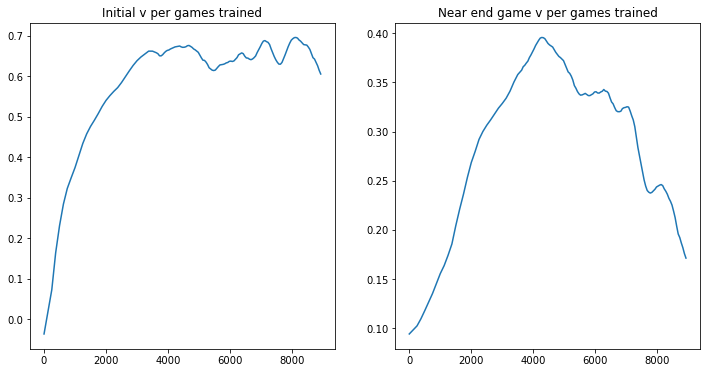

In [22]:
import matplotlib.pyplot as plt

initial_game_state_v = []
end_game_state_v = []
games_ = []
bn_ = BrandubNet()
gs_ = get_initial_game_state()

for i in range(135):
    
    checkpoint_ = torch.load('saved_models/checkpoint_' + str(i))
    bn_.load_state_dict(checkpoint_['model_state_dict'])
    
    _, v_ = bn_.forward(gs_)
    initial_game_state_v.append(v_)
    
    _, v_ = bn_.forward(gs2)
    end_game_state_v.append(v_)
    
    if i > 28:
        total_games = 250 + 125 * 27 + 50 * (i - 28)
    elif i > 0:
        total_games = 250 + 125 * (i - 1)
    else:
        total_games = 0
        
    games_.append(total_games)
    
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title('Initial v per games trained')
ax[0].plot(games_, initial_game_state_v)

ax[1].set_title('Near end game v per games trained')
ax[1].plot(games_, end_game_state_v)

plt.show()

## Conclusion?

I believe that we are making progress. I think we just need to keep running the $*@#&! out of
this simulation and hope that we eventually learn something a little more real. Frankly,
it probably sees the early game so much that it has a better idea of what it wants to do there.